# Autoencoders for Transfer Learning

This is an experiment to find out how well the encoder model performs when finetuned on image classification task.

The motivation behind this experiment is to create a upstream model that can be trained on large amount of unlabelled data and then use it on a downstream task with fewer labelled data, or to create image encoder for clustering.

## Experiment Setup

We will be comparing two sets of model: 
1. A CNN pretrained on an upstream dataset and then finetuned on a downstream dataset 
2. An Autoencoder pretrained on the upstream dataset and then its encoder finetuned on the downstream dataset

Datasets:
* Upstream: [Fruit 360](https://www.kaggle.com/datasets/moltean/fruits)
* Downstream: [Vegetable Image Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset)

The CNN models used will have VGG like architecture


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os
from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

## Data Preparation

In [2]:
IMG_SIZE = (96, 96, 3)
BATCH_SIZE = 32
EPOCHS = 20

images_u_train = glob("../input/fruits/fruits-360_dataset/fruits-360/Training/*/*")
images_u_valid = glob("../input/fruits/fruits-360_dataset/fruits-360/Test/*/*")
targets_u = os.listdir("../input/fruits/fruits-360_dataset/fruits-360/Training/")

images_d_train = glob("../input/vegetable-image-dataset/Vegetable Images/train/*/*")
images_d_valid = glob("../input/vegetable-image-dataset/Vegetable Images/test/*/*")
targets_d = os.listdir("../input/vegetable-image-dataset/Vegetable Images/train/")

In [3]:
def load_images_clf_u(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE[:-1])    
    label = tf.strings.split(imagePath, os.path.sep)[-2]
    
    oneHot = label == targets_u
    encodedLabel = tf.argmax(oneHot)

    return (image, encodedLabel)

def load_images_clf_d(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE[:-1])    
    label = tf.strings.split(imagePath, os.path.sep)[-2]
    
    oneHot = label == targets_d
    encodedLabel = tf.argmax(oneHot)

    return (image, encodedLabel)

def load_images_enc(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE[:-1])

    return (image, image)

In [4]:
def get_callbacks(log_path):
    return [
        CSVLogger(log_path), 
        ReduceLROnPlateau(patience=3, verbose=1, min_delta=1e-3),
        EarlyStopping(min_delta=1e-3, patience=7, verbose=1, restore_best_weights=True)
    ]

# Pretraining Autoencoder

In [5]:
inputs = keras.Input(shape=IMG_SIZE, name='encoder_inputs')
x = L.Conv2D(32, 3, padding='same', activation='relu', name='encoder_conv_1_1')(inputs)
x = L.Dropout(0.2, name="encoder_drop_1")(x)
x = L.Conv2D(32, 3, padding='same', activation='relu', name='encoder_conv_1_2')(x)
x = L.MaxPool2D(padding='same', name='encoder_pool_1')(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='encoder_conv_2_1')(x)
x = L.Dropout(0.2, name="encoder_drop_2")(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='encoder_conv_2_2')(x)
encoded = L.MaxPool2D(padding='same', name='encoder_pool_2')(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='decoder_conv_1_1')(encoded)
x = L.Dropout(0.2, name="decoder_drop_1")(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='decoder_conv_1_2')(x)
x = L.UpSampling2D(name='decoder_upsample_1')(x)
x = L.Conv2D(32, 3, padding='same', activation='relu', name='decoder_conv_2_1')(x)
x = L.Dropout(0.2, name="decoder_drop_2")(x)
x = L.Conv2D(32, 3, padding='same', activation='relu', name='decoder_conv_2_2')(x)
x = L.UpSampling2D(name='decoder_upsample_2')(x)
outputs = L.Conv2D(3, 1, padding='same', activation='sigmoid', name='decoder_output')(x)

autoencoder = Model(inputs=inputs, outputs=outputs, name='autoencoder')
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

2022-08-03 04:23:18.264487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:23:18.423816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:23:18.424578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:23:18.426753: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 96, 96, 3)]       0         
_________________________________________________________________
encoder_conv_1_1 (Conv2D)    (None, 96, 96, 32)        896       
_________________________________________________________________
encoder_drop_1 (Dropout)     (None, 96, 96, 32)        0         
_________________________________________________________________
encoder_conv_1_2 (Conv2D)    (None, 96, 96, 32)        9248      
_________________________________________________________________
encoder_pool_1 (MaxPooling2D (None, 48, 48, 32)        0         
_________________________________________________________________
encoder_conv_2_1 (Conv2D)    (None, 48, 48, 64)        18496     
_________________________________________________________________
encoder_drop_2 (Dropout)     (None, 48, 48, 64)        

node zero
2022-08-03 04:23:20.779246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:23:20.780162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:23:20.780919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 04:23:20.781572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
enc_train = (
    Dataset.from_tensor_slices(images_u_train)
    .shuffle(1024)
    .map(load_images_enc, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)
enc_valid = (
    Dataset.from_tensor_slices(images_u_valid)
    .shuffle(1024)
    .map(load_images_enc, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)

2022-08-03 04:23:21.703131: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-08-03 04:23:23.386836: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2116/2116 [==============================] - 303s 140ms/step - loss: 0.3536 - val_loss: 0.3592
Epoch 2/20
2116/2116 [==============================] - 50s 24ms/step - loss: 0.3492 - val_loss: 0.3465
Epoch 3/20
2116/2116 [==============================] - 50s 23ms/step - loss: 0.3479 - val_loss: 0.3465
Epoch 4/20
2116/2116 [==============================] - 50s 24ms/step - loss: 0.3487 - val_loss: 0.3458
Epoch 5/20
2116/2116 [==============================] - 50s 24ms/step - loss: 0.3475 - val_loss: 0.3449
Epoch 6/20
2116/2116 [==============================] - 50s 24ms/step - loss: 0.3471 - val_loss: 0.3447
Epoch 7/20
2116/2116 [==============================] - 50s 23ms/step - loss: 0.3480 - val_loss: 0.3504
Epoch 8/20
2116/2116 [==============================] - 50s 23ms/step - loss: 0.3470 - val_loss: 0.3469

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/20
2116/2116 [==============================] - 50s 24ms/step - loss: 0.3466 - val_loss

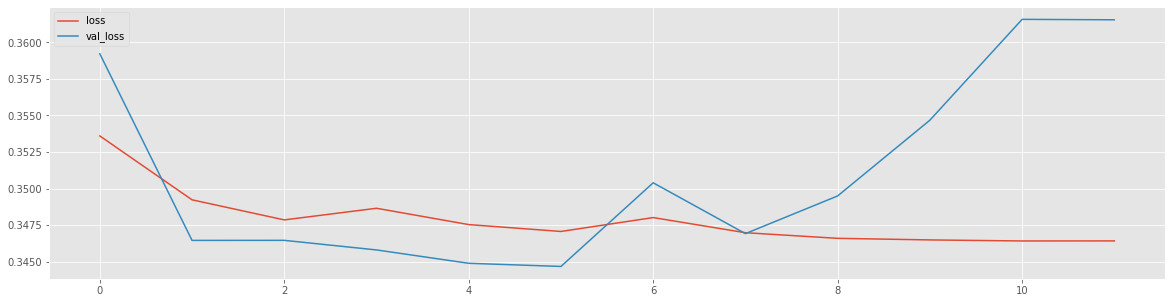

In [7]:
history_ae_u = autoencoder.fit(
    enc_train, validation_data=enc_valid,epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, 
    callbacks=get_callbacks('autoencoder_pretraining.csv')
)
encoder_base = keras.Model(inputs, encoded, name='encoder_base')
encoder_base.save('encoder_base.h5')

hist_df = pd.DataFrame(history_ae_u.history)
fig, ax = plt.subplots(figsize=(20, 5))
hist_df.iloc[:, :-1].plot(ax=ax);

In [8]:
del enc_train, enc_valid, autoencoder, encoder_base

# Pretraining CNN

In [9]:
inputs = keras.Input(shape=IMG_SIZE, name='cnn_inputs')
x = L.Conv2D(32, 3, padding='same', activation='relu', name='cnn_conv_1_1')(inputs)
x = L.Dropout(0.2, name="cnn_drop_1")(x)
x = L.Conv2D(32, 3, padding='same', activation='relu', name='cnn_conv_1_2')(x)
x = L.MaxPool2D(padding='same', name='cnn_pool_1')(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='cnn_conv_2_1')(x)
x = L.Dropout(0.2, name="cnn_drop_2")(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='cnn_conv_2_2')(x)
encoded = L.MaxPool2D(padding='same', name='cnn_pool_2')(x)
x = L.Flatten(name='cnn_flatten')(encoded)
outputs = L.Dense(len(targets_u), activation='softmax', name='cnn_classification_head')(x)

cnn = Model(inputs=inputs, outputs=outputs, name='cnn')
cnn.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_inputs (InputLayer)      [(None, 96, 96, 3)]       0         
_________________________________________________________________
cnn_conv_1_1 (Conv2D)        (None, 96, 96, 32)        896       
_________________________________________________________________
cnn_drop_1 (Dropout)         (None, 96, 96, 32)        0         
_________________________________________________________________
cnn_conv_1_2 (Conv2D)        (None, 96, 96, 32)        9248      
_________________________________________________________________
cnn_pool_1 (MaxPooling2D)    (None, 48, 48, 32)        0         
_________________________________________________________________
cnn_conv_2_1 (Conv2D)        (None, 48, 48, 64)        18496     
_________________________________________________________________
cnn_drop_2 (Dropout)         (None, 48, 48, 64)        0       

In [10]:
clf_train = (
    Dataset.from_tensor_slices(images_u_train)
    .shuffle(1024)
    .map(load_images_clf_u, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)
clf_valid = (
    Dataset.from_tensor_slices(images_u_valid)
    .shuffle(1024)
    .map(load_images_clf_u, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)

Epoch 1/20
2116/2116 [==============================] - 182s 86ms/step - loss: 1.0736 - accuracy: 0.7994 - val_loss: 11.6134 - val_accuracy: 0.0977
Epoch 2/20
2116/2116 [==============================] - 31s 15ms/step - loss: 0.2751 - accuracy: 0.9397 - val_loss: 15.5896 - val_accuracy: 0.1327
Epoch 3/20
2116/2116 [==============================] - 31s 15ms/step - loss: 0.0936 - accuracy: 0.9782 - val_loss: 17.2517 - val_accuracy: 0.1338
Epoch 4/20
2116/2116 [==============================] - 31s 15ms/step - loss: 0.0621 - accuracy: 0.9858 - val_loss: 16.5699 - val_accuracy: 0.1160

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20
2116/2116 [==============================] - 31s 15ms/step - loss: 0.1529 - accuracy: 0.9688 - val_loss: 10.1296 - val_accuracy: 0.2309
Epoch 6/20
2116/2116 [==============================] - 31s 15ms/step - loss: 0.0724 - accuracy: 0.9837 - val_loss: 9.7392 - val_accuracy: 0.2683
Epoch 7/20
2116/2116 [==============

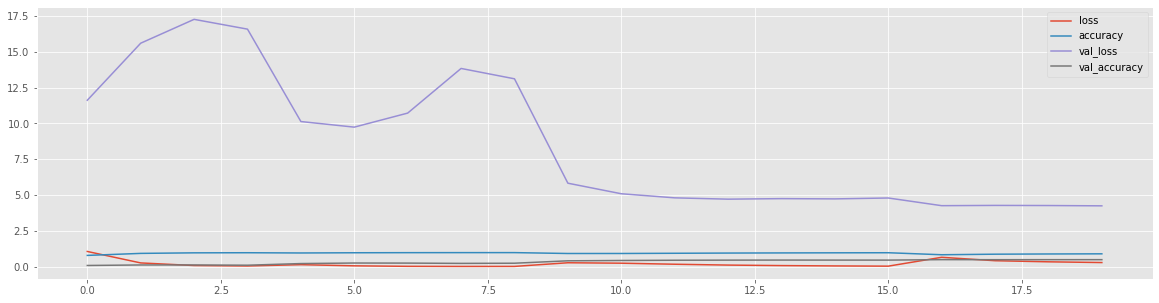

In [11]:
history_cnn_u = cnn.fit(
    clf_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(clf_valid), 
    callbacks=get_callbacks('cnn_pretraining.csv')
)
cnn_base = keras.Model(inputs, encoded, name='cnn_base')
cnn_base.save('cnn_base.h5')

hist_df = pd.DataFrame(history_cnn_u.history)
fig, ax = plt.subplots(figsize=(20, 5))
hist_df.iloc[:, :-1].plot(ax=ax);

In [12]:
del clf_train, clf_valid, cnn, cnn_base

## Finetuning

In [13]:
d_clf_train = (
    Dataset.from_tensor_slices(images_d_train)
    .shuffle(1024)
    .map(load_images_clf_d, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)
d_clf_valid = (
    Dataset.from_tensor_slices(images_d_valid)
    .shuffle(1024)
    .map(load_images_clf_d, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)

# Finetuning Encoder

Epoch 1/20
469/469 [==============================] - 83s 175ms/step - loss: 1.6372 - accuracy: 0.4965 - val_loss: 4.6255 - val_accuracy: 0.1133
Epoch 2/20
469/469 [==============================] - 6s 14ms/step - loss: 1.2126 - accuracy: 0.6359 - val_loss: 4.5028 - val_accuracy: 0.1543
Epoch 3/20
469/469 [==============================] - 7s 14ms/step - loss: 0.6923 - accuracy: 0.7805 - val_loss: 3.9376 - val_accuracy: 0.2000
Epoch 4/20
469/469 [==============================] - 7s 15ms/step - loss: 0.4415 - accuracy: 0.8587 - val_loss: 3.9462 - val_accuracy: 0.2710
Epoch 5/20
469/469 [==============================] - 6s 14ms/step - loss: 0.3323 - accuracy: 0.8959 - val_loss: 3.5031 - val_accuracy: 0.2997
Epoch 6/20
469/469 [==============================] - 7s 14ms/step - loss: 0.2479 - accuracy: 0.9227 - val_loss: 3.4479 - val_accuracy: 0.3283
Epoch 7/20
469/469 [==============================] - 7s 14ms/step - loss: 0.1953 - accuracy: 0.9418 - val_loss: 3.0781 - val_accuracy: 0.38

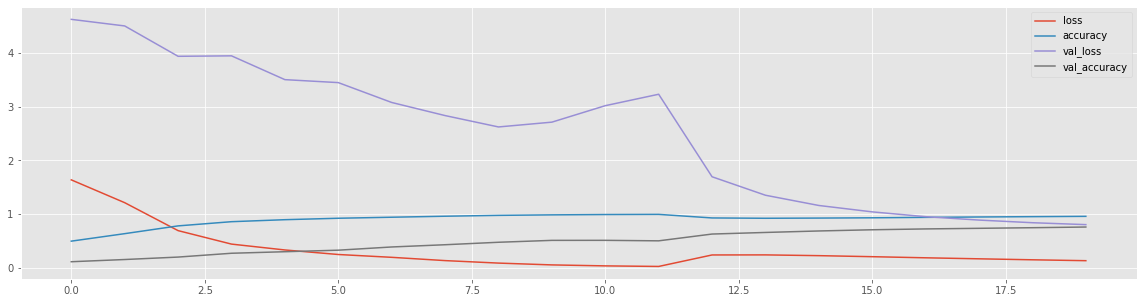

In [14]:
encoder = Sequential([
    load_model('encoder_base.h5'),
    L.Flatten(name='encoder_flatten'),
    L.Dense(len(targets_d), activation='softmax', name='encoder_classification_head')
])
encoder.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_ae_d = encoder.fit(
    d_clf_train, validation_data=d_clf_valid, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True,
    callbacks=get_callbacks('autoencoder_finetuning.csv')
)
encoder.save('encoder_finetuned.h5')

loss, accuracy = encoder.evaluate(d_clf_valid)
print(f"\n\nAccuracy of Autoencoder Finetuned Classifier: {accuracy}")

hist_df = pd.DataFrame(history_ae_d.history)
fig, ax = plt.subplots(figsize=(20, 5))
hist_df.iloc[:, :-1].plot(ax=ax);

# Finetuning CNN

Epoch 1/20
469/469 [==============================] - 7s 14ms/step - loss: 1.7738 - accuracy: 0.4617 - val_loss: 4.3075 - val_accuracy: 0.0793
Epoch 2/20
469/469 [==============================] - 6s 14ms/step - loss: 1.4885 - accuracy: 0.5350 - val_loss: 4.6685 - val_accuracy: 0.1170
Epoch 3/20
469/469 [==============================] - 6s 14ms/step - loss: 0.9631 - accuracy: 0.6887 - val_loss: 3.6114 - val_accuracy: 0.1523
Epoch 4/20
469/469 [==============================] - 6s 14ms/step - loss: 0.7538 - accuracy: 0.7626 - val_loss: 3.1397 - val_accuracy: 0.2263
Epoch 5/20
469/469 [==============================] - 6s 14ms/step - loss: 0.6036 - accuracy: 0.8111 - val_loss: 2.5212 - val_accuracy: 0.2690
Epoch 6/20
469/469 [==============================] - 6s 14ms/step - loss: 0.4217 - accuracy: 0.8671 - val_loss: 2.5711 - val_accuracy: 0.3100
Epoch 7/20
469/469 [==============================] - 6s 14ms/step - loss: 0.3097 - accuracy: 0.9047 - val_loss: 2.6833 - val_accuracy: 0.3287

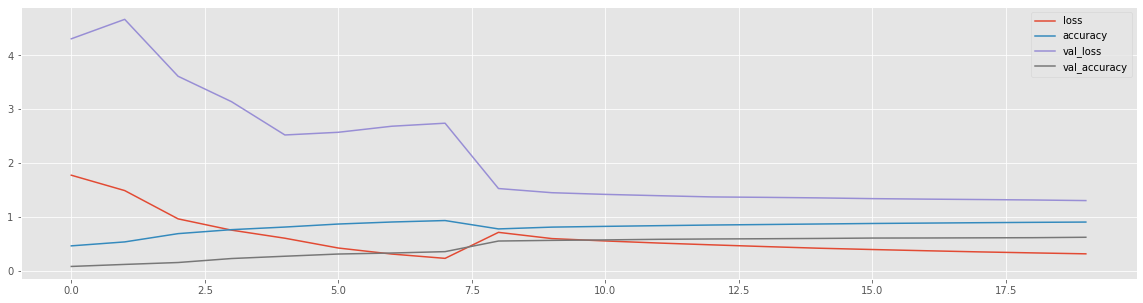

In [15]:
cnn = Sequential([
    load_model('cnn_base.h5'),
    L.Flatten(name='cnn_flatten'),
    L.Dense(len(targets_d), activation='softmax', name='cnn_classification_head')
])
cnn.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_cnn_d = cnn.fit(
    d_clf_train, validation_data=d_clf_valid, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True,
    callbacks=get_callbacks('cnn_finetuning.csv')
)
encoder.save('cnn_finetuned.h5')
loss, accuracy = encoder.evaluate(d_clf_valid)
print(f"\n\nAccuracy of CNN Finetuned Classifier: {accuracy}")

hist_df = pd.DataFrame(history_cnn_d.history)
fig, ax = plt.subplots(figsize=(20, 5))
hist_df.iloc[:, :-1].plot(ax=ax);

## 